<a href="https://colab.research.google.com/github/lfernandof/lfp_signals_analysis/blob/main/participation_ratio_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [212]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import json
import scipy
import seaborn as sns

# ACCESS TO DATA
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [213]:
# LOAD SESSION DATA: SPIKES FROM TRIALS AND INTER-TRIAL INTERVALS (ITI)
session_data = pd.read_csv('/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels//data/session_data-spikes.csv').copy()

In [214]:
# LOAD OFF-SESSION DATA: SPIKES FROM SLEEP (REM, NREM) AND FREELY MOVING PERIODS
all_scored_states = pd.read_csv('/content/drive/MyDrive/backup-mac/ufabc/entire-backup/lfp/all_channels//data/all_scored_states.csv',index_col='Unnamed: 0')

# Participation ratio early and late in session (using trials' data)

Spikes from each trial are convolved and then averaged over N trials (N = 1/3 of the session with least trials). This average spiking activity is lowered in resolution (averaged over 100 ms time windows), its mean is subtracted and therefrom a covariance matrix is built. The participation ratio is estimated from the eigenvalues of this covariance matrix.

In [215]:
'''Functions:
- separate a (big) dataframe into a list of dfs each with data from a single rat
- check trials for sufficient neurons and spikes
- build a discrete firing matrix by binning a dataframe
- convolve a time-binned spike matrix
- separate dataframes from different rats
- lower firing rate resolution
- estimate participation ratio
'''

def separate_rats(dataframe,check_num_neurons=True,min_num_neurons = 2):
    #Separate the dataframe by rat, and store each part as an entry in a list

    # INPUT:
    # - dataframe
    # - check_num_neurons: check whether a rat in this dataframe has less than min_num_neurons (default: True)
    # - min_num_neurons: the least amount of neurons an animal has to have in order to be included (default: 2)

    # OUTPUT:
    # - rats: a list of DataFrames, each entry being the subset of the main DataFrame with the spikes from one rat

    rats = []
    for rat in dataframe['rat'].unique():

        #Check whether a rat has only one registered neuron in the dataset
        if check_num_neurons:
            if dataframe.loc[dataframe['rat']==rat].neuron.nunique() < min_num_neurons:
                #If it's less than min_num_neurons, skip to the next animal
                continue
            #If one's not checking (check_num_neurons = False) or the animal has sufficient neurons, save it
        rats.append(dataframe.loc[dataframe['rat'] == rat])
    return rats #an array of dataframes (!)

def least_amount_neurons(dataset,num_cells_threshold = 4):
    #Drop trials with less than a given amount of neurons out of the dataset and find the least amount of units among all remaining trials that is not below this threshold

    #INPUT:
    # - dataset: pandas DataFrame [pd.df] (for columns and descriptions: see _specifications_)
    # - num_cells_threshold: the least amount of neurons required for inclusion of that trial

    #OUTPUT:
    # - pruned_dataset: the dataset (pd.df) cleared of the data pertaining to trials with less neurons than needed
    # - min_num_units: the minimum number of neurons all the remaining cells possess

    #Make a copy, so it'll not alter the given dataset
    pruned_dataset = dataset.copy()

    #Set the minimum amount of neurons to a high initial value
    min_num_units = 10_000 #a ludicrous amount of neurons

    #Check each trial for their number of neurons
    for trial in dataset.trial.unique():
        #if it falls below the threshold, remove it from the pruned_dataset
        if dataset.loc[dataset['trial'] == trial].neuron.nunique() < num_cells_threshold:
            pruned_dataset.drop(pruned_dataset.loc[pruned_dataset['trial']==trial].index,inplace=True)
            pass #skip to the next trial, so not to alter min_num_units with this trial

        #if it is not lower than this least amount, check if it is less than what was set to be the minimum so far
        elif dataset.loc[dataset['trial'] == trial].neuron.nunique() < min_num_units:
            min_num_units = dataset.loc[dataset['trial'] == trial].neuron.nunique()

    return pruned_dataset,min_num_units

def least_amount_spikes(dataset,num_spikes_threshold = 4):
    #Drop trials with less than a given amount of spikes out of the dataset

    #INPUT:
    # - dataset: pandas DataFrame [pd.df] (for columns and descriptions: see _specifications_)
    # - num_spikes_threshold: the least amount of neurons required for inclusion of that trial

    #OUTPUT:
    # - pruned_dataset: the dataset (pd.df) cleared of the data pertaining to trials with less spikes than required

    #Make a copy, so it'll not alter the given dataset
    pruned_dataset = dataset.copy()

    #Check each trial for their number of neurons
    for trial in dataset.trial.unique():
        #if it falls below the threshold, remove it from the pruned_dataset
        if len(dataset.loc[dataset['trial'] == trial]) < num_spikes_threshold:
            pruned_dataset.drop(pruned_dataset.loc[pruned_dataset['trial']==trial].index,inplace=True)

    return pruned_dataset

def time_binning(spikes_df,timespan=[0,1.5]):

  #Transform the spikes DataFrame into a 3D np.ndarray whose dimensions are (trials,neurons,timebins)

  # INPUT:
  # - dataset [pandas DataFrame]
  # - timespan [list(float)]: the timestamp boundaries in which all spikes to be binned lie within (in s; default = [0s,1.5s])

  # OUTPUT:
  # - binned_spikes: a trials x neurons x timebins matrix

  #just in case the dataset is not sorted by trial
  dataset = spikes_df.sort_values('trial').copy()

  num_trials = dataset.trial.nunique()
  num_neurons = dataset.neuron.nunique()

  duration = timespan[1] - timespan[0]
  num_timebins = int(duration*1000)

  binned_spikes_matrix = np.zeros([num_trials,num_neurons,num_timebins])

  for trial_id,trial in enumerate(dataset.trial.unique()):
    for neuron_id,neuron in enumerate(dataset.neuron.unique()):
      spike_train = dataset.loc[(dataset['trial'] == trial) & (dataset['neuron'] == neuron)]
      discretized_spike_train,edges = np.histogram(spike_train.time,bins = np.linspace(timespan[0],timespan[1],num_timebins+1,endpoint=True))
      binned_spikes_matrix[trial_id,neuron_id,:] = discretized_spike_train

  return binned_spikes_matrix

def convolve_raster(binned_spikes):
    #Convolve a matrix containing the raster plots (time histogram of spikes) for all neurons in all trials

    #INPUT:
    # - binned_spikes: a trials x neurons x timebins matrix
    # - width: the kernel width, in ms
    # - sd: I haven't figured it out exactly yet: lower values widen the kernel shape and larger ones sharpen it
    #the authors didn't call it SD, I am extrapolating from my knowledge on gaussian filtering (might be wrong)

    #OUTPUT:
    # - convolved [np.ndarray(int,int,float)]: a trials x neurons x timebins matrix of convolved spiking activity

    x = np.linspace(0,750,750) #750 ms in 750 points

    kernel = np.exp(-x/100)
    kernel = np.pad(kernel,(750,0),'constant') #center the kernel at 0

    #uncomment these to plot the kernel
    #plt.figure()
    #plt.title('Decaying exponential kernel')
    #plt.plot(np.arange(0,len(x)),decaying_exp)

    #uncomment these to plot evidence that the kernel drops to 1/e over the course of 100ms
    #plt.figure()
    #plt.title('Decaying exponential kernel')
    #plt.plot(np.arange(0,len(x)),decaying_exp)


    #create a matrix with the same dimensions as the binned rasters' to accommodate the convolved rasters
    all_neurons_convolved = np.zeros(np.shape(binned_spikes))
    #print(np.shape(all_neurons_convolved))

    #the # of trials, neurons and timebins are given by:
    trials,neurons,timebins = np.shape(binned_spikes)

    for trial in range(trials):
        for neuron in range(neurons):
            all_neurons_convolved[trial,neuron,:] = np.convolve(kernel,binned_spikes[trial,neuron,:]
                                                            ,mode='full')[750:-749]

    return all_neurons_convolved

def lower_firing_rate_resolution(spike_activity_matrix,time_window_size=100):

  '''
  Lower the resolution of a firing rate matrix with dimensions neurons x time bins by averaging over a window

  INPUT:
  - spike_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x time, in which each element (i,j) of the matrix represents the firing rate of neuron i at the j-th time bin
  - time_window_size [int]: time window over which the firing rates will be averaged (in ms)

  OUTPUT:
  - lowres_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x low_restime_bins, in which each element (i,j) of the matrix
                                            represents the firing rate of neuron i at the j-th low resolution time bin (by default of 100 ms width)
  '''

  (num_neurons,num_timebins) = np.shape(spike_activity_matrix)

  lowres_timebins = int(num_timebins/time_window_size)

  lowres_activity_matrix = np.zeros([num_neurons,lowres_timebins])

  for time_bin in range(lowres_timebins):
    lowres_activity_matrix[:,time_bin] = np.mean(spike_activity_matrix[:,time_bin*100:(time_bin+1)*100],axis=1)

  return lowres_activity_matrix

def participation_ratio(spike_activity_matrix):
  '''
  Obtain the participation ratio of neurons (see Ganguli et al., 2017, https://doi.org/10.1101/214262) from a Z-scored activity matrix with its firing rates over time

  INPUT:
  - spike_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x time, in which each element (i,j) of the matrix represents the firing rate of neuron i at the j-th time bin
  OUTPUT:
  - participation_ratio [float]: a real value bound beetween [1,M] (M is the number of neurons) describing the number of dimensions required to describe the population activity
  '''

  #if the matrix has been normalized (the sum over columns differ from zero) then normalize it by subtracting the average of each neuron from all of its time bins
  if not np.isclose(np.sum(spike_activity_matrix,axis=0),np.zeros(len(np.sum(spike_activity_matrix,axis=0)))).all():
    #Z-scoring so each column sums up to 0
    spike_activity_matrix = spike_activity_matrix - spike_activity_matrix.mean(axis=0, keepdims=True)

  #Estimate the covariance
  #cov = spike_activity_matrix.T @ spike_activity_matrix / len(spike_activity_matrix)
  cov = np.cov(spike_activity_matrix)

  (L, P) = np.linalg.eigh(cov) #(eigenvalues, eigenvectors) of the covariance matrix yield the directions of most variance (e.g. firing patterns encompassing multiple neurons)

  #estimate the dimensionality
  participation_ratio = (np.sum(L))**2/np.sum([eigenvalue**2 for eigenvalue in L])

  return participation_ratio

def z_scored_participation_ratio(spike_activity_matrix):
  '''
  Obtain the participation ratio of neurons (see Ganguli et al., 2017, https://doi.org/10.1101/214262) from a Z-scored activity matrix with its firing rates over time

  INPUT:
  - spike_activity_matrix [NumPy ndarray]: a 2D ndarray with dimensions neurons x time, in which each element (i,j) of the matrix represents the firing rate of neuron i at the j-th time bin
  OUTPUT:
  - participation_ratio [float]: a real value bound beetween [1,M] (M is the number of neurons) describing the number of dimensions required to describe the population activity
  '''

  #if the matrix has been normalized (the sum over columns differ from zero) then normalize it by subtracting the average of each neuron from all of its time bins
  if not np.isclose(np.sum(spike_activity_matrix,axis=0),np.zeros(len(np.sum(spike_activity_matrix,axis=0)))).all():
    #Z-scoring so each column sums up to 0
    spike_activity_matrix = scipy.stats.zscore(spike_activity_matrix,axis=0) # - spike_activity_matrix.mean(axis=0, keepdims=True)

  #Estimate the covariance
  #cov = spike_activity_matrix.T @ spike_activity_matrix / len(spike_activity_matrix)
  cov = np.cov(spike_activity_matrix)

  (L, P) = np.linalg.eigh(cov) #(eigenvalues, eigenvectors) of the covariance matrix yield the directions of most variance (e.g. firing patterns encompassing multiple neurons)

  #estimate the dimensionality
  participation_ratio = (np.sum(L))**2/np.sum([eigenvalue**2 for eigenvalue in L])

  return participation_ratio

## Pool neurons from all animals

Pool neurons from each animal (yields a matrix with dimensions [trials, neurons, timebins]) and separate its trials according to the aforemention early/late division.

In [216]:
def pooled_neurons_early_late(separated_rats_list,binning_timespan = [-0.5,1.5],lowres_binning_span=100):

  '''
  Clip each trial within the temporal range specified by "binning_timespan", binarize in a 1-ms-resolution, convolve with an exponential kernel with a 100 ms smoothing window, lower the temporal resolution
  to 100 ms bins and store this in a matrix with dimensions trial x neuron x time bin for each animal. Then average trials over the early/late periods from each rat and pool the neurons across animals
  to yield two matrices (early, late) with dimensions neurons x time bin, which represents activity from all neurons (i.e. from all animals) recorded in that day/region.

  INPUT:
  - separated_rats: a list of DataFrames, each entry being the subset of the main DataFrame with the spikes from one rat. See separate_rats() above for more information.
  - binning_timespan [list[float]]: the timespan in which to trim each trial (e.g. the first 1s, from [0,1]) (given in seconds, default: from -0.5 s to 1.5 s, [-0.5,1.5])
  - lowres_binning_span [int]: length (in time) of each bin for lowering the resolution of the firing rate (given in ms, default: 100)

  OUTPUT:
  - lowres_pooled_activity_matrices [NumPy ndarray]: two matrices (early, late) with dimensions neurons x time bin, which represents activity from all neurons recorded in that day/region
  '''

  #Find the session with the least trials and truncate all other sessions at this count, so that early/late comparisons across animals make sense
  #P.S.: If we only got the first/last third of trials (or the first/last N trials) from each animal we would be comparing extremely different distributions
  #e.g. fetching the first and last ones from the animal that made ~200 trials is way different than the same and last from the animal with more than a 1000 attempts
  #Our chosen (and rather conservative) approach is to truncate all sessions at the amount of rewarded trials from the animal with the least
  least_amount_of_trials = min([animal.trial.nunique() for animal in separated_rats_list])
  trials_in_thirds = int(least_amount_of_trials/3)
  print(f'Trial count in the shortest session: {least_amount_of_trials}. Trials in early/late session (thirds of this shortest trial count): {trials_in_thirds}')

  #the number of unique neurons is less than the total number of neurons because some of different rat's neurons have the same numeric value corresponding to them:
  neurons_count = 0

  rats_dfs = []
  for rat in separated_rats_list:
    #pruned_df = least_amount_spikes(rat,10)

    print('rat',rat.rat.unique()[0],' has ', rat.neuron.nunique(),' different neurons')
    neurons_count+= rat.neuron.nunique()

    rats_dfs.append(rat)

  #print('number of "unique" neurons according to pandas: ',data_subset.neuron.nunique(),' \nActual count of unique neurons: ',neurons_count)

  #make a recipient for all of a region's neurons;after convolving and taking the mean, this will be the number of bins we will reduce our series to
  num_timebins = int(1000*(binning_timespan[1] - binning_timespan[0])/lowres_binning_span) #multiply the numerator by 1000 because it is in seconds and the denominator is in miliseconds

  first_trials_activty_matrix = np.empty([neurons_count,num_timebins])
  last_trials_activty_matrix = np.empty([neurons_count,num_timebins])

  session_slice = trials_in_thirds #number of trials we avereage over

  #Binarize, convolve and lower the resolution of the activity for each rat, then aggregate them into a pooled activity matrix
  neuron_count = 0

  for current_rat_df in rats_dfs:
    current_num_neurons = current_rat_df.neuron.nunique()

    #bin in time
    binned = time_binning(current_rat_df,timespan = [-0.5,1.5])
    #convolve and trim the matrix up to the maximum number of trials in the rat with least trials
    convolved = convolve_raster(binned)[0:least_amount_of_trials,:,:]

    #average over N trials (N first, N last)
    first_mean_convolved = np.expand_dims(np.mean(convolved[0:session_slice,:,:],axis=0),axis=0)
    last_mean_convolved = np.expand_dims(np.mean(convolved[-session_slice:,:,:],axis=0),axis=0)

    #lower the resolution and store in the pooled activity matrix for each segment (early or late in session)
    for i in range(num_timebins):
      first_trials_activty_matrix[neuron_count:neuron_count+current_num_neurons,i] = np.mean(first_mean_convolved[0,:,i*100:(i+1)*100],axis=1)
      last_trials_activty_matrix[neuron_count:neuron_count+current_num_neurons,i] = np.mean(last_mean_convolved[0,:,i*100:(i+1)*100],axis=1)

    neuron_count+= current_num_neurons

  return first_trials_activty_matrix,last_trials_activty_matrix


def pool_comparison_plot(pool1_data,pool2_data,plot_title='',individual_heatmap_titles=['','']):
  '''
  Plot two heatmaps side by side, colored with the same colormap and scale. Each represents the activity in neurons pooled from either region/day/stage.

  INPUT:
  - pool_data: a 2D matrix (neurons x timebins)
  '''

  import matplotlib
  from matplotlib.colors import Normalize
  import matplotlib.cm as cm

  fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,8))

  cmap = matplotlib.colormaps['viridis']
  normalizer=Normalize(0,max(pool1_data.max(),pool2_data.max())) #find the maximum firing rate and normalize from 0 up to it
  im = cm.ScalarMappable(norm=normalizer)

  sns.heatmap(pool1_data[:,:],cmap='viridis',norm=normalizer,ax=axes[0],cbar=False)
  sns.heatmap(pool2_data[:,:],cmap='viridis',norm=normalizer,ax=axes[1],cbar=False)

  fig.colorbar(im, ax=axes.ravel().tolist())

  fig.suptitle(plot_title)
  axes[0].set_title(individual_heatmap_titles[0])
  axes[1].set_title(individual_heatmap_titles[1])

  axes[0].set_ylabel('Neurons (#)')
  axes[1].set_ylabel('Neurons (#)')

  axes[0].set_xlabel(r'Time bins ($\times 100$ ms)')
  axes[1].set_xlabel(r'Time bins ($\times 100$ ms)')

  plt.show()

def bootstrapped_pools_participation_ratio_comparison(pool1_data,pool2_data,nruns=1000,alpha=0.95,two_tailed=True,figlabel=None):
  '''
  Create pairs of neuron pool resamples by sampling without replacement from a matrix stacking activity in both pools.
  Estimate the participation ratio (PR) in the original matrices and in each resample.
  Create differences from the original pools and for each pair of resamples by subtracting the PR in the 2nd pool from the PR in the 1st.

  Return the participation ratio for the input pools, the distribution of participation ratios over the resamples and statistics (confidence
  interval boundaries) of whether the original value.
  '''

  combined_samples = np.vstack((pool1_data,pool2_data))

  diffs = []
  abs = []

  for _ in range(nruns):
    #create two random samples by resampling with replacement the combined neuron pool from both conditions; the number of sampled neurons is the same as the least in both conditions
    #(ex: the region with least neurons has 50 neurons, all samples will have this number)
    sample1 = np.random.choice(np.shape(combined_samples)[0],np.shape(pool1_data)[0],replace=False)
    sample2 = np.random.choice(np.shape(combined_samples)[0],np.shape(pool2_data)[0],replace=False)

    #estimate the difference in participation ratios from matrices with neurons corresponding to each sample and store this in a distribution of participation ratio differences
    abs.append(participation_ratio(combined_samples[sample1,:]))
    abs.append(participation_ratio(combined_samples[sample2,:]))
    diffs.append(participation_ratio(combined_samples[sample1,:]) - participation_ratio(combined_samples[sample2,:]))

  original_diff = participation_ratio(pool1_data) - participation_ratio(pool2_data)


  # confidence intervals
  if two_tailed:
    lower = np.percentile(diffs,((1-alpha)/2)*100) #e.g. at 95% confidence: 0.05/2 * 100 => 2.5%
    upper = np.percentile(diffs,((alpha+(1-alpha)/2))*100) #e.g. at 95% confidence: (0.95 + 0.025) * 100 => 97.5%
  else:
    lower =  np.percentile(diffs, (1-alpha)*100)
    upper =  np.percentile(diffs, alpha*100)

  print(lower,upper)

  #check for significance
  significant = (original_diff > upper) or (original_diff < lower)

  #plot the histogram of differences in bootstrapped matrices and the line corresponding to the difference between the original neuron pools' matrices
  plt.figure(figsize=(10,8))
  counts,bins,patches = plt.hist(diffs,color='#EE6123',density=True)
  plt.title(figlabel)
  plt.xlabel('Difference between participation ratios (a.u.)')
  plt.ylabel('Probability of occurrence')
  plt.fill_betweenx([0, plt.gca().get_ylim()[1]], lower, upper, color='#FA003F', alpha=0.1, label='Difference range\nconsistent with the null hypothesis')
  plt.axvline(original_diff, color='#254441', linestyle='--',label='Difference in the original matrices')

  plt.legend()
  plt.show()

  return original_diff,diffs,upper,lower,significant,abs

In [217]:
def loc_and_separate(data,day_id,region_id,trial_duration_criteria,spike_time_criteria,check_num_neurons=False):
  '''Find the activity pertaining to trials in each session (day, region) that are eligible (minimum and maximum duration, number of neurons)'''
  data_subset = data.loc[(data['day']== day_id) & (data['region']== region_id)
                    & (data['duration']>=trial_duration_criteria[0]) & (data['duration']<=trial_duration_criteria[1])
                    & (data['time']>=spike_time_criteria[0]) & (data['time']<=spike_time_criteria[1])]
  return separate_rats(data_subset,check_num_neurons)

In [218]:
'''Pool the data '''
# Select the in-session data
data = session_data.copy()

# Build the dataframes containing only spikes from eligible trials
PFC_d1 = loc_and_separate(data,day_id = 1, region_id = 'PFC', trial_duration_criteria=[1.5,3.5], spike_time_criteria = [-0.5,1.5])
PFC_d2 = loc_and_separate(data,day_id = 2, region_id = 'PFC', trial_duration_criteria=[1.5,3.5], spike_time_criteria = [-0.5,1.5])

STR_d1 = loc_and_separate(data,day_id = 1, region_id = 'STR', trial_duration_criteria=[1.5,3.5], spike_time_criteria = [-0.5,1.5])
STR_d2 = loc_and_separate(data,day_id = 2, region_id = 'STR', trial_duration_criteria=[1.5,3.5], spike_time_criteria = [-0.5,1.5])

# Pool neurons from each rat in a given session and separate them into early/late matrices
early_PFC_g2d1,late_PFC_g2d1 = pooled_neurons_early_late(PFC_d1)
early_STR_g2d1,late_STR_g2d1 = pooled_neurons_early_late(STR_d1)
early_PFC_g2d2,late_PFC_g2d2 = pooled_neurons_early_late(PFC_d2)
early_STR_g2d2,late_STR_g2d2 = pooled_neurons_early_late(STR_d2)

Trial count in the shortest session: 147. Trials in early/late session (thirds of this shortest trial count): 49
rat 7  has  17  different neurons
rat 8  has  35  different neurons
rat 9  has  10  different neurons
rat 10  has  9  different neurons
rat 3  has  4  different neurons
rat 4  has  33  different neurons
rat 5  has  5  different neurons
rat 6  has  4  different neurons
Trial count in the shortest session: 147. Trials in early/late session (thirds of this shortest trial count): 49
rat 3  has  12  different neurons
rat 4  has  26  different neurons
rat 5  has  16  different neurons
rat 6  has  1  different neurons
Trial count in the shortest session: 175. Trials in early/late session (thirds of this shortest trial count): 58
rat 3  has  14  different neurons
rat 4  has  28  different neurons
rat 5  has  5  different neurons
rat 6  has  3  different neurons
Trial count in the shortest session: 175. Trials in early/late session (thirds of this shortest trial count): 58
rat 3  has

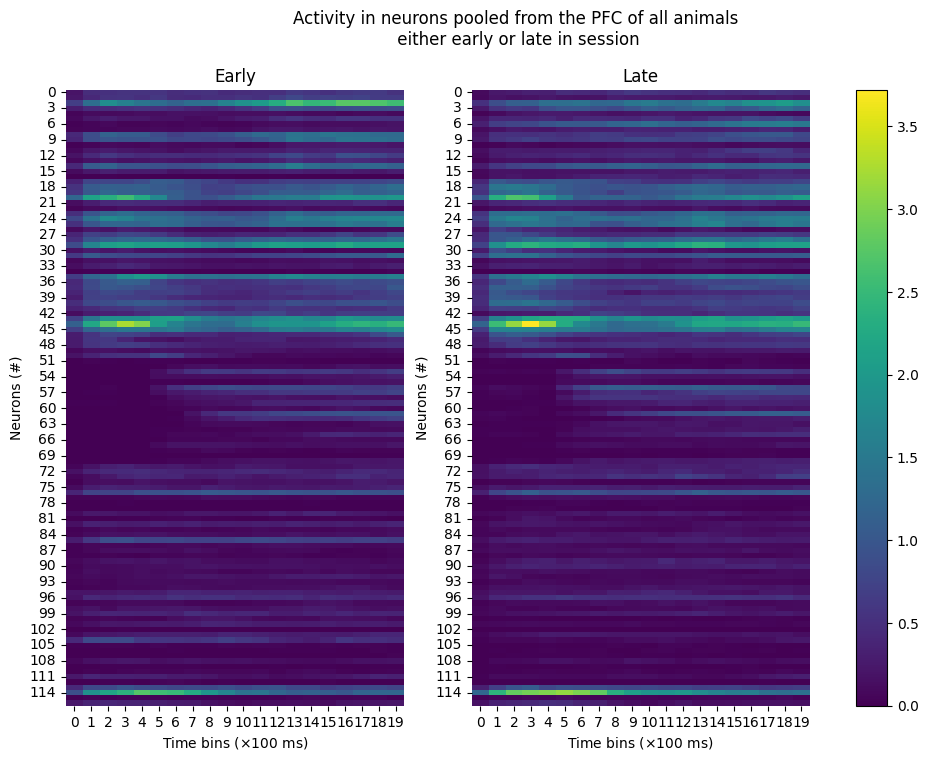

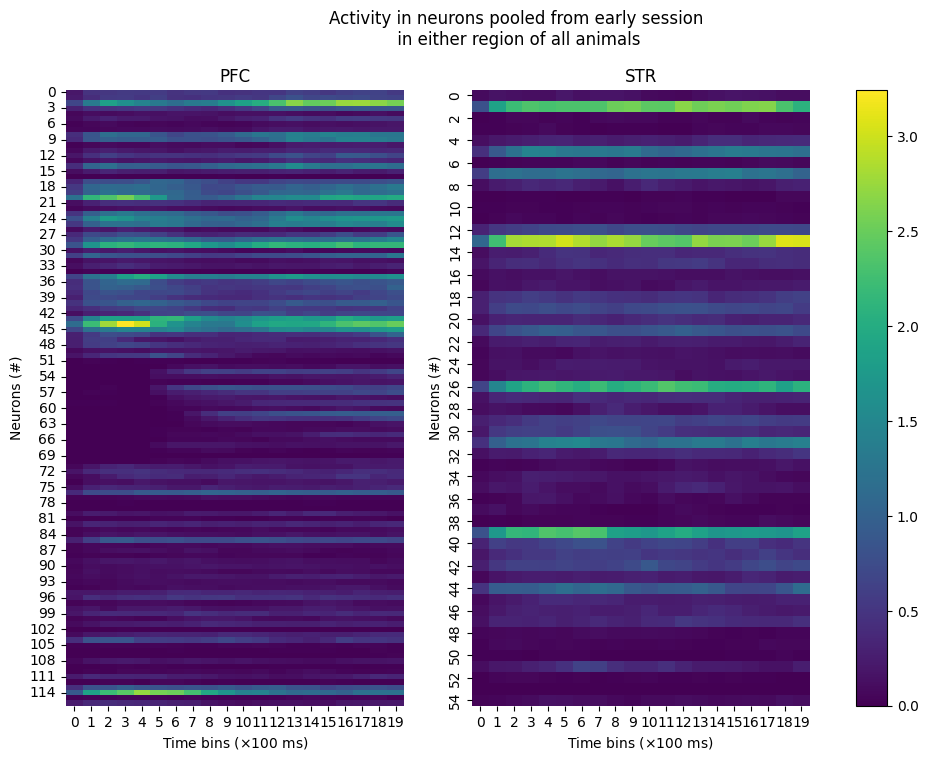

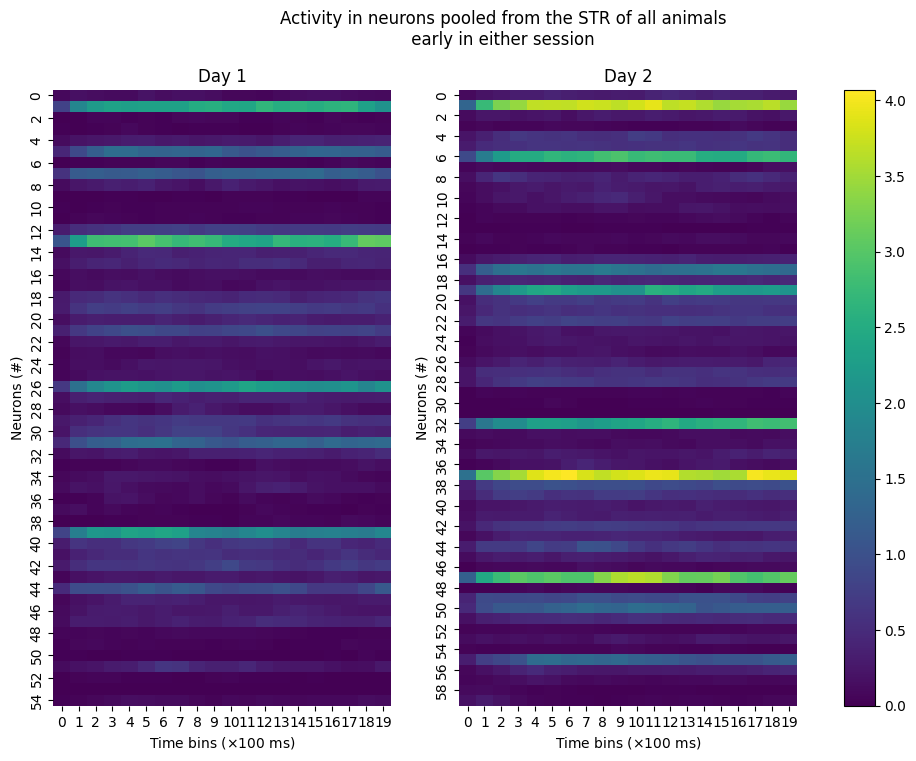

In [219]:
#Example usages of the plotting function/possible comparisons (days, stages or regions)

#comparing session stages in the same region
pool_comparison_plot(early_PFC_g2d1,late_PFC_g2d1,'Activity in neurons pooled from the PFC of all animals\n either early or late in session',individual_heatmap_titles=['Early','Late'])

#comparing both regions
pool_comparison_plot(early_PFC_g2d1,early_STR_g2d1,'Activity in neurons pooled from early session\n in either region of all animals',individual_heatmap_titles=['PFC','STR'])

#comparing both days
pool_comparison_plot(early_STR_g2d1,early_STR_g2d2,'Activity in neurons pooled from the STR of all animals\n early in either session ',individual_heatmap_titles=['Day 1','Day 2'])

-0.5165869635392979 1.2755254583624975


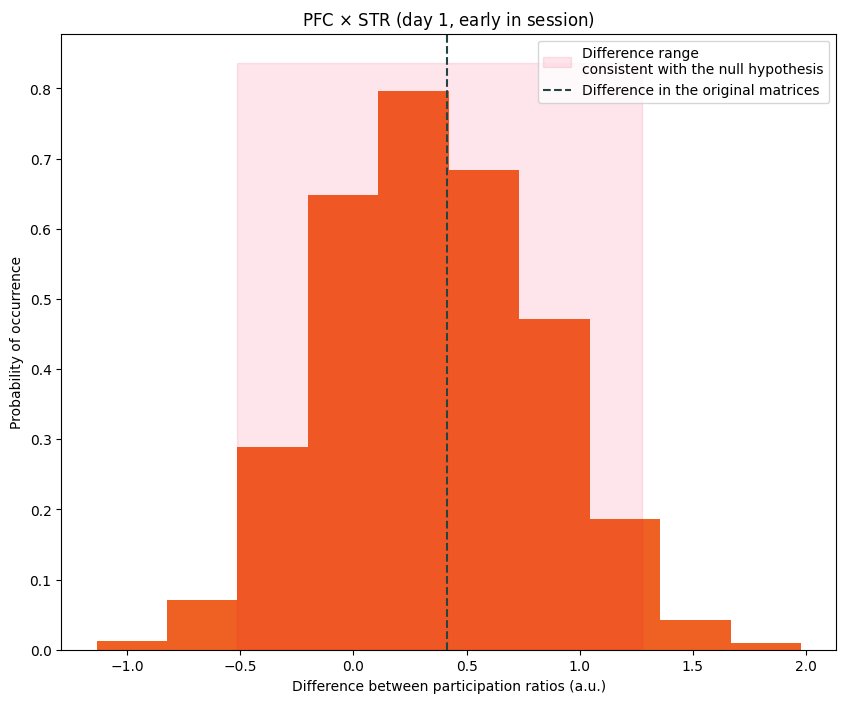

-0.6795951584715313 0.8408366610921765


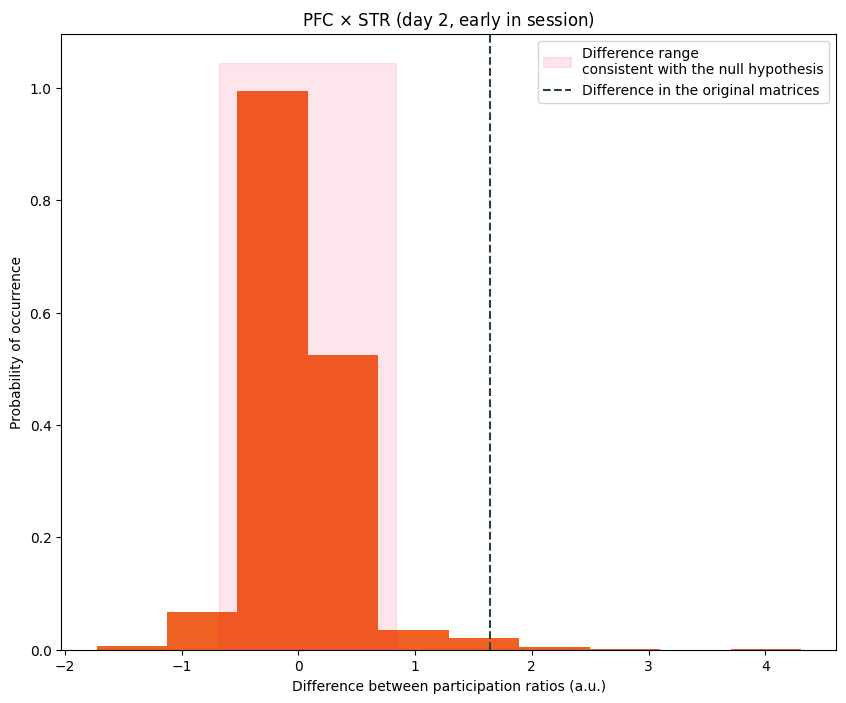

-0.5189534014930293 0.9932047280117768


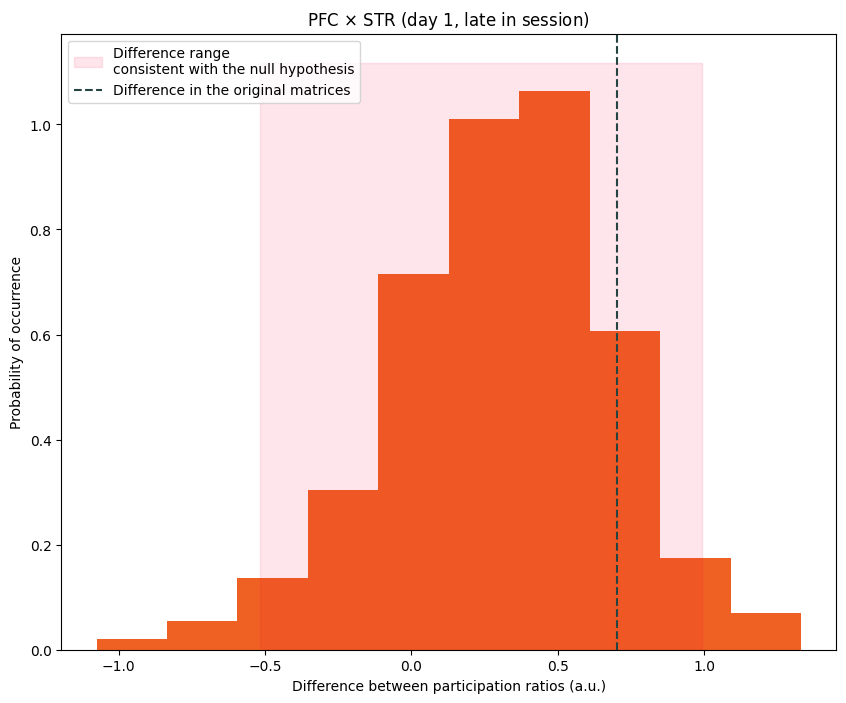

-0.9618742401764027 1.2325604963554375


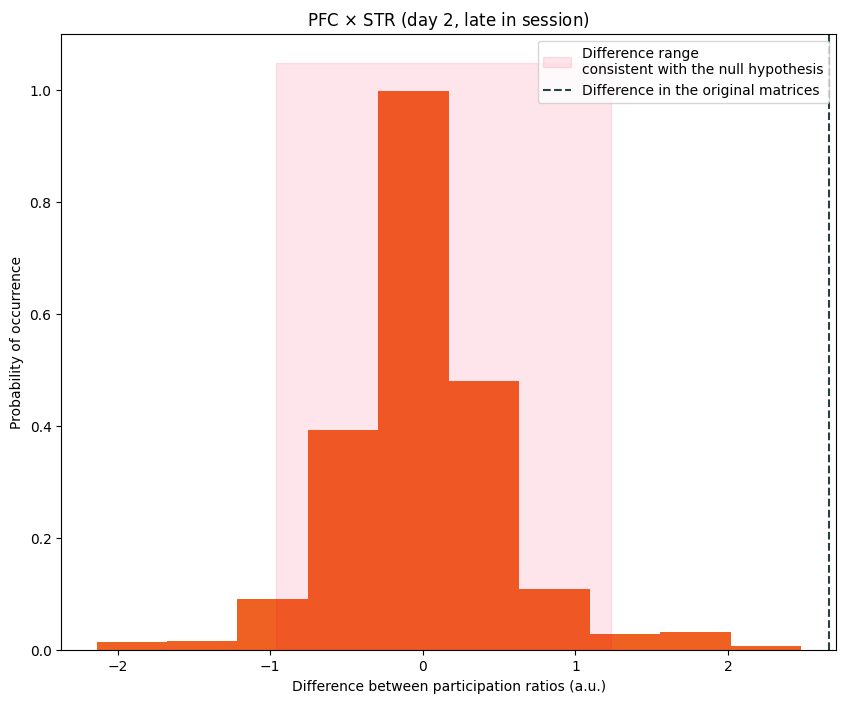

In [220]:
#PFC vs. STR comparison (in the same day/session period)
pfc_str_d1_early = bootstrapped_pools_participation_ratio_comparison(early_PFC_g2d1,early_STR_g2d1,nruns=1000,two_tailed=True,figlabel=r'PFC $\times$ STR (day 1, early in session)')
pfc_str_d2_early = bootstrapped_pools_participation_ratio_comparison(early_PFC_g2d2,early_STR_g2d2,nruns=1000,two_tailed=True,figlabel=r'PFC $\times$ STR (day 2, early in session)')

pfc_str_d1_late = bootstrapped_pools_participation_ratio_comparison(late_PFC_g2d1,late_STR_g2d1,nruns=1000,two_tailed=True,figlabel=r'PFC $\times$ STR (day 1, late in session)')
pfc_str_d2_late = bootstrapped_pools_participation_ratio_comparison(late_PFC_g2d2,late_STR_g2d2,nruns=1000,two_tailed=True,figlabel=r'PFC $\times$ STR (day 2, late in session)')

-0.6664814121888615 1.263481332312708


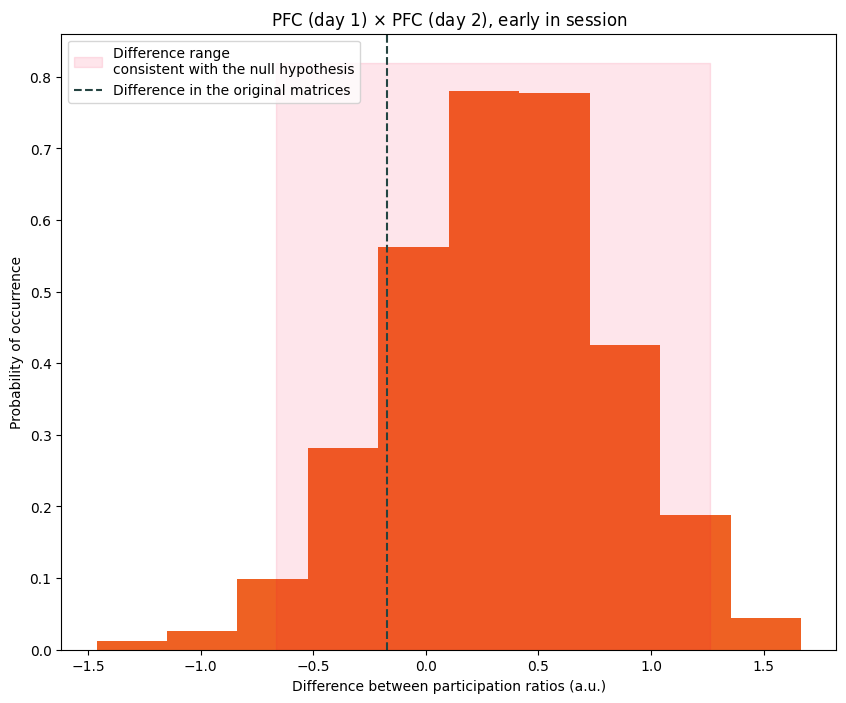

-0.5215368936188234 1.0773574134546837


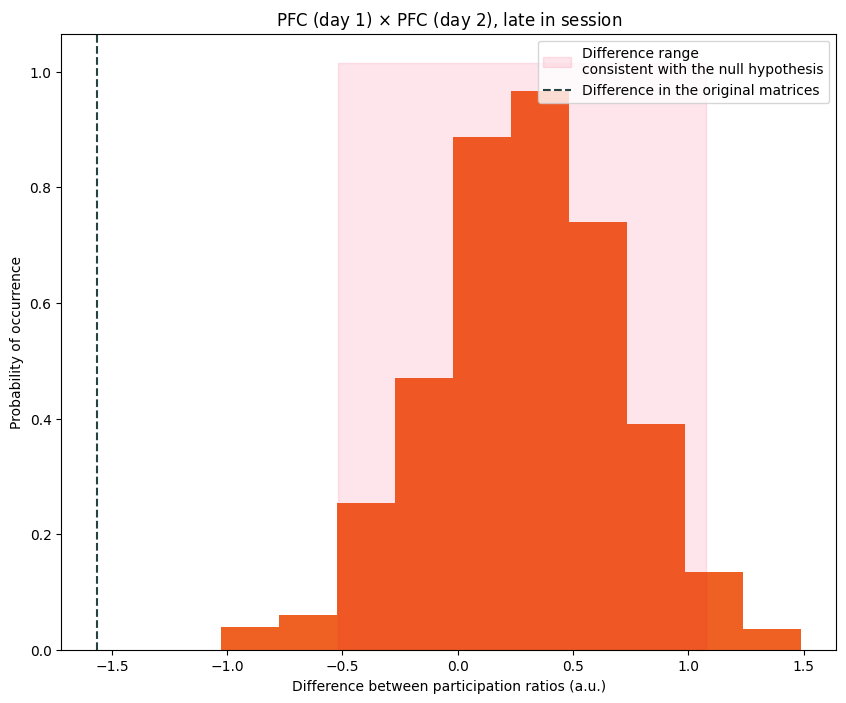

-0.6690036650175113 0.6756034818997726


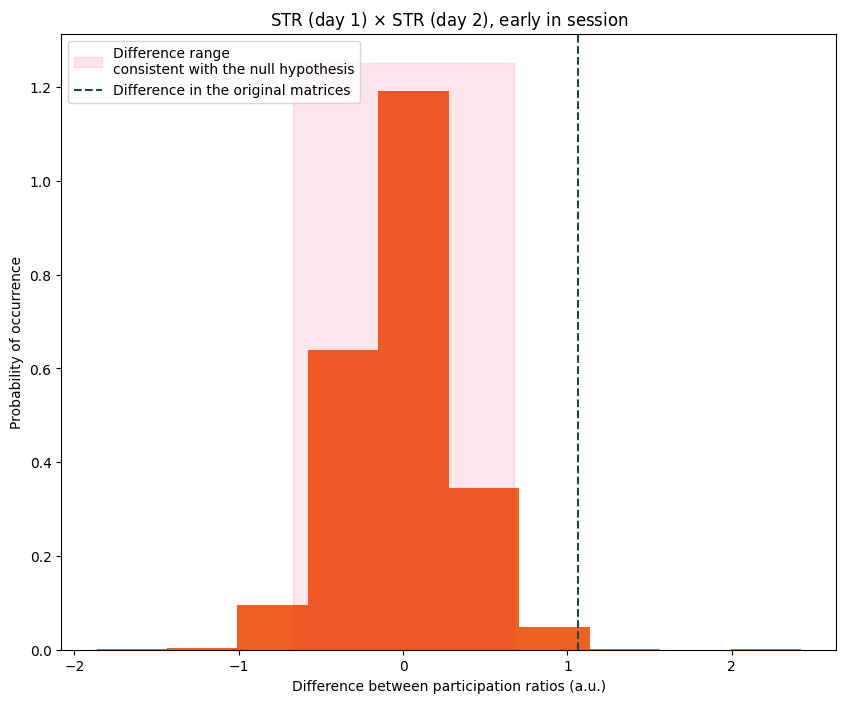

-0.7992785939990462 0.8776319530122666


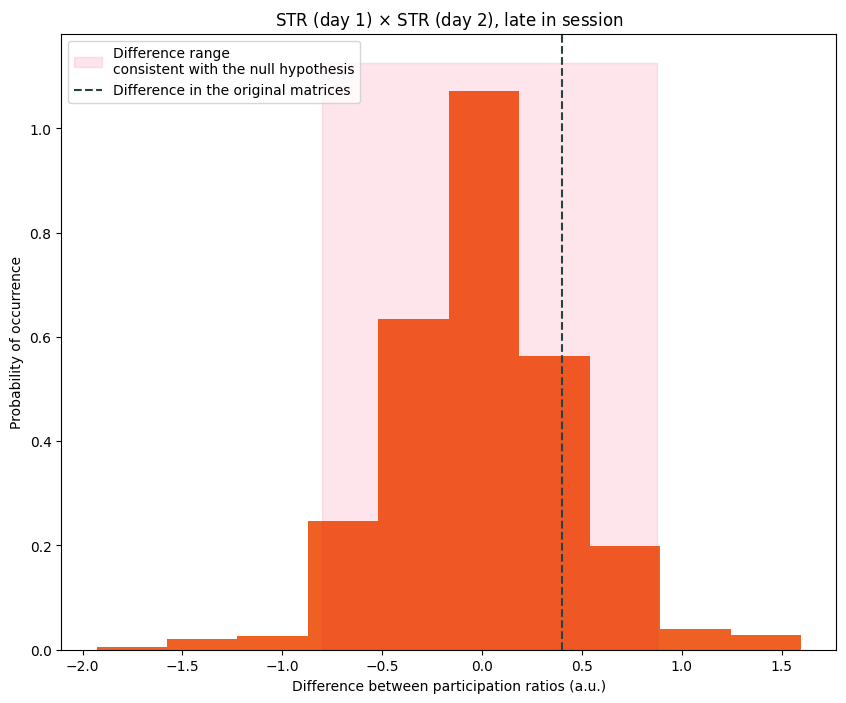

In [221]:
#Within region comparison between days (in the same session period)
pfc_d1_d2_early = bootstrapped_pools_participation_ratio_comparison(early_PFC_g2d1,early_PFC_g2d2,nruns=1000,two_tailed=True,figlabel=r'PFC (day 1) $\times$ PFC (day 2), early in session')
pfc_d1_d2_early = bootstrapped_pools_participation_ratio_comparison(late_PFC_g2d1,late_PFC_g2d2,nruns=1000,two_tailed=True,figlabel=r'PFC (day 1) $\times$ PFC (day 2), late in session')

str_d1_d2_early = bootstrapped_pools_participation_ratio_comparison(early_STR_g2d1,early_STR_g2d2,nruns=1000,two_tailed=True,figlabel=r'STR (day 1) $\times$ STR (day 2), early in session')
str_d1_d2_late = bootstrapped_pools_participation_ratio_comparison(late_STR_g2d1,late_STR_g2d2,nruns=1000,two_tailed=True,figlabel=r'STR (day 1) $\times$ STR (day 2), late in session')

# Participation ratio in random freely moving segments

Spikes from randomly selected 2-second windows from freely moving behavior either prior to training or after it (i.e. out of session) are convolved and then averaged over N exemplars (N = 1/3 of the session with least trials for the in-session analyses of the same session [region, day]). This average spiking activity is lowered in resolution (averaged over 100 ms time windows), its mean is subtracted and therefrom a covariance matrix is built. The participation ratio is estimated from the eigenvalues of this covariance matrix.

In [222]:
def time_binning_stages(spikes_df,timespan=[0,1.5]):

  #Transform the spikes DataFrame into a 3D np.ndarray whose dimensions are (trials,neurons,timebins)

  # INPUT:
  # - dataset [pandas DataFrame]
  # - timespan [list(float)]: the timestamp boundaries in which all spikes to be binned lie within (in s; default = [0s,1.5s])

  # OUTPUT:
  # - binned_spikes: a trials x neurons x timebins matrix

  #just in case the dataset is not sorted by trial
  dataset = spikes_df.sort_values('stage_id').copy()

  num_stages = dataset.stage_id.nunique()
  num_neurons = dataset.neuron.nunique()

  duration = timespan[1] - timespan[0]
  num_timebins = int(duration*1000)

  binned_spikes_matrix = np.zeros([num_stages,num_neurons,num_timebins])

  for stage_id,stage in enumerate(dataset.stage_id.unique()):
    stage_beginning = dataset.loc[dataset['stage_id'] == stage].timestamp.min()
    for neuron_id,neuron in enumerate(dataset.neuron.unique()):
      spike_train = dataset.loc[(dataset['stage_id'] == stage) & (dataset['neuron'] == neuron)]
      discretized_spike_train,edges = np.histogram(spike_train.timestamp - stage_beginning,bins = np.linspace(timespan[0],timespan[1],num_timebins+1,endpoint=True))
      binned_spikes_matrix[stage_id,neuron_id,:] = discretized_spike_train

  return binned_spikes_matrix

def random_stage_clipping(single_rat_df,clipped_duration=2):
  # Select a random segment of variable length (window size: clipped_duration) from a out-of-session-like DataFrame, binarize, convolve and lower its resolution.

  # INPUT:
  # - single_rat_df [pandas DataFrame]: pandas DataFrame containing data from a single rat (format: out-of-session-like DataFrame; e.g. containing "stage_id")
  # - clipped_duration [float]: the time window length (in s)

  # OUTPUT:
  # - binned_spikes: a trials x neurons x timebins matrix
  segment_length = 0

  while segment_length == 0:
    #guaranteed to run at least once, but run until we find a segment with at least 2 s in duration with spikes recorded within its time boundaries
    random_stage = np.random.choice(single_rat_df.stage_id.unique())

    stage_session = single_rat_df.query(f'stage_id == {random_stage}')

    import random
    window_left = random.uniform(stage_session.timestamp.min(),stage_session.timestamp.max()-clipped_duration) #left end of the time window to be selected

    session_segment = stage_session.query(f'timestamp > {window_left} and timestamp < {window_left + clipped_duration}')
    segment_length = len(session_segment)

  lowres_segment_spikes = lower_firing_rate_resolution(convolve_raster(time_binning_stages(session_segment,[0,clipped_duration]))[0,:,:])

  return lowres_segment_spikes

def participation_ratio_distribution_trialLike(separated_rats_dfs,num_segments,num_reps=1000):
  '''
  Build a participation ratio distribution in randomly selected freely moving segments.

  INPUT:
  - separated_rats_dfs [list(pandas DataFrame)]: list whose elements are pandas DataFrames, each featuring data from a single rat
  - num_segments [int]: number of trial-like segments to be averaged over. e.g.: the "early trials" matrix for in-session analysis
                        is an average of 100 trials; when comparing this session to freely moving periods, use 100 randomly selected
                        freely moving intervals to build the surrogate dataset.
  -  num_reps [int]: size of the participation ratio distribution

  OUTPUT:
  - pr_dist[list]: participation ratio values over averaged pools of neurons that are randomly selected at each iteration
  '''
  pr_dist = []

  for _ in range(num_reps):
    random_pools = []
    for _ in range(num_segments):
      #warning: the resulting pools might have differing number of neurons
      random_pools.append(np.vstack([matrix for matrix in map(random_stage_clipping,separated_rats_dfs)]))

    #find the pool with the least neurons:
    min_num_neurons = min([np.shape(pool)[0] for pool in random_pools])

    #cut every matrix at this inferior threshold for neuron count to allow for averaging
    truncated_pools = [matrix[0:min_num_neurons,:] for matrix in random_pools]
    average_pool = np.mean(truncated_pools,axis=0)

    #print(participation_ratio(average_pool))
    pr_dist.append(participation_ratio(average_pool))

  return pr_dist

def least_amount_of_trials(separated_rats_dfs):
  least = min([animal.trial.nunique() for animal in separated_rats_dfs])
  thirds = int(least/3)

  return least,thirds

In [223]:
# Build participation ratio distributions for freely moving periods in each session
reps = 100

pr_dist_PFC_d1 = participation_ratio_distribution_trialLike(separate_rats(all_scored_states.query(f'day == 1 and stage == "WAKEstate" and region == "PFC"'),check_num_neurons=False),
                                                  num_segments = least_amount_of_trials(PFC_d1)[1],num_reps = reps)
pr_dist_PFC_d2 = participation_ratio_distribution_trialLike(separate_rats(all_scored_states.query(f'day == 2 and stage == "WAKEstate" and region == "PFC"'),check_num_neurons=False),
                                                  num_segments = least_amount_of_trials(PFC_d2)[1],num_reps = reps)
pr_dist_STR_d1 = participation_ratio_distribution_trialLike(separate_rats(all_scored_states.query(f'day == 1 and stage == "WAKEstate" and region == "STR"'),check_num_neurons=False),
                                                  num_segments = least_amount_of_trials(STR_d1)[1],num_reps = reps)
pr_dist_STR_d2 = participation_ratio_distribution_trialLike(separate_rats(all_scored_states.query(f'day == 2 and stage == "WAKEstate" and region == "STR"'),check_num_neurons=False),
                                                  num_segments = least_amount_of_trials(STR_d1)[1],num_reps = reps)

In [224]:
def pr_comparison_inSession_freelyMoving(axis,freelymoving_pr_dist,inSession_pools,hist_color='red',line_colors=['#f54542','#8c0200'],axis_title='',alpha=0.95,two_tailed_test=True):
  axis.hist(freelymoving_pr_dist,color=hist_color,alpha=0.4,label='Awake (non-session) periods')

  axis.axvline(x=participation_ratio(inSession_pools[0]),label='Early in session',linestyle='dotted',color=line_colors[0],linewidth = 2.5)
  axis.axvline(x=participation_ratio(inSession_pools[1]),label='Late in session',linestyle='dashed',color=line_colors[1],linewidth = 2.5)

  axis.set_title(axis_title)
  axis.set_xlabel('Participation ratio (a.u.)')
  axis.set_ylabel('Counts (#)')

  # confidence intervals
  if two_tailed_test:
    lower = np.percentile(freelymoving_pr_dist,((1-alpha)/2)*100) #e.g. at 95% confidence: 0.05/2 * 100 => 2.5%
    upper = np.percentile(freelymoving_pr_dist,((alpha+(1-alpha)/2))*100) #e.g. at 95% confidence: (0.95 + 0.025) * 100 => 97.5%
  else:
    lower =  np.percentile(freelymoving_pr_dist, (1-alpha)*100)
    upper =  np.percentile(freelymoving_pr_dist, alpha*100)
  axis.fill_betweenx([0, plt.gca().get_ylim()[1]], lower, upper, color='grey', alpha=0.1, label='Difference range\nconsistent with the null hypothesis')

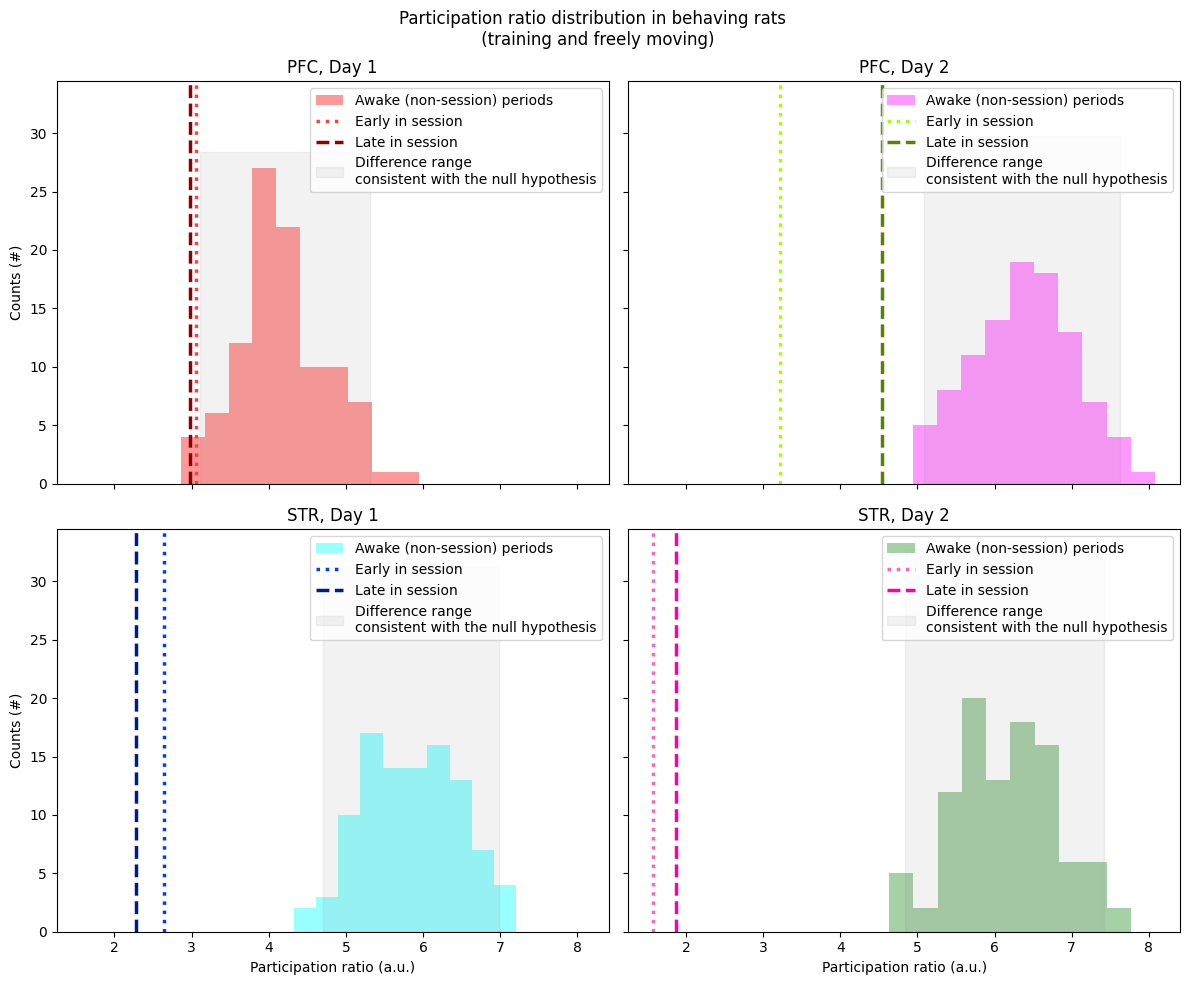

In [225]:
# Plot all 4 panels featuring the participation ratio for in-session (lines) and freely moving surrogates (histograms)
fig, axs = plt.subplots(2,2,figsize=(12,10),sharey=True,sharex=True,)

pr_dists = [pr_dist_PFC_d1,pr_dist_PFC_d2,pr_dist_STR_d1,pr_dist_STR_d2]
pool_pairs = [(early_PFC_g2d1,late_PFC_g2d1),(early_PFC_g2d2,late_PFC_g2d2),(early_STR_g2d1,late_STR_g2d1),(early_STR_g2d2,late_STR_g2d2)]
hist_colors = ['red','fuchsia','cyan','forestgreen']
line_color_pairs = [('#f54542','#8c0200'),('#a3ff05','#548500'),('#003cff','#001e80'),('#ff63c9','#ff00a6')]
titles = ['PFC, Day 1','PFC, Day 2','STR, Day 1','STR, Day 2']

for i,ax in enumerate(axs.flatten()):
  pr_comparison_inSession_freelyMoving(axis=ax,freelymoving_pr_dist=pr_dists[i],inSession_pools=pool_pairs[i],hist_color=hist_colors[i],
                                       line_colors=line_color_pairs[i],axis_title=titles[i],two_tailed_test=True)
  ax.legend()
  ax.label_outer()

fig.suptitle('Participation ratio distribution in behaving rats \n (training and freely moving)')
plt.tight_layout()

# Fig. 1: exemplifying how neural activity matrices are built

Elements for the figure to be built on inkscape later on

In [226]:
# Raster plot from spikes

# In-session:
rats_STR_d1 = loc_and_separate(session_data,day_id = 1,region_id = 'STR',trial_duration_criteria=[1.5,3.5],spike_time_criteria=[-0.5,1.5])
binned_spikes_demo = time_binning(rats_STR_d1[1])

# Out-of-session:
#binned_spikes_demo = time_binning_stages(all_scored_states.query('rat == 3 and day == 1 and stage == "WAKEstate"'))

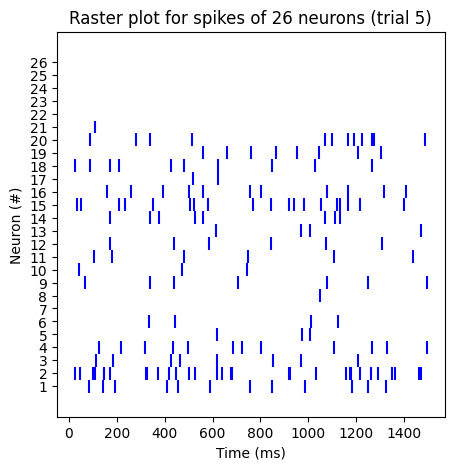

In [227]:
#Raster from the first trial (in-session) or first segment (out-of-session):
num_neurons,segment_duration = np.shape(binned_spikes_demo[0,:,:])

plt.figure(figsize=(5,5))
plt.title(f'Raster plot for spikes of {num_neurons} neurons (trial 5)') #5 is the first rewarded trial
plt.xlabel('Time (ms)')
plt.yticks(range(0,num_neurons),labels=range(1,num_neurons+1))
plt.ylabel('Neuron (#)')

#An eventplot does not work with a binary array, so we pass the indexes at which an event (spike) happens instead
plt.eventplot([np.where(binned_spikes_demo[0,current_neuron,:] == 1)[0] for current_neuron in range(num_neurons)],color='blue');

Text(45.722222222222214, 0.5, 'Neuron (#)')

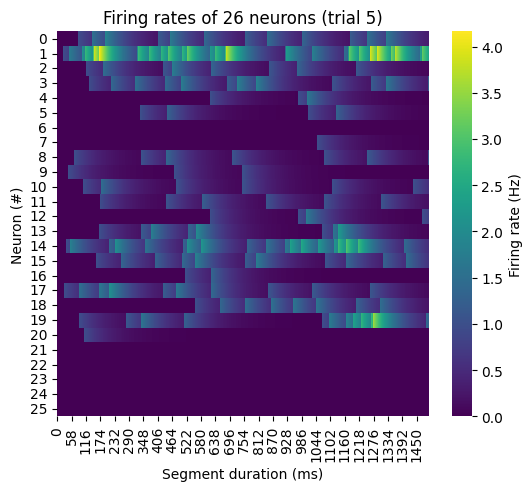

In [228]:
# Convolution from this raster
firing_rates = convolve_raster(binned_spikes_demo)

fig, ax = plt.subplots(figsize=(6, 5))

ax = sns.heatmap(firing_rates[0,:,:],cmap='viridis',cbar_kws={'label': 'Firing rate (Hz)'})

ax.set_title(f'Firing rates of {num_neurons} neurons (trial 5)')
ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Segment duration (ms)')
ax.set_ylabel('Neuron (#)')

Text(45.722222222222214, 0.5, 'Neuron (#)')

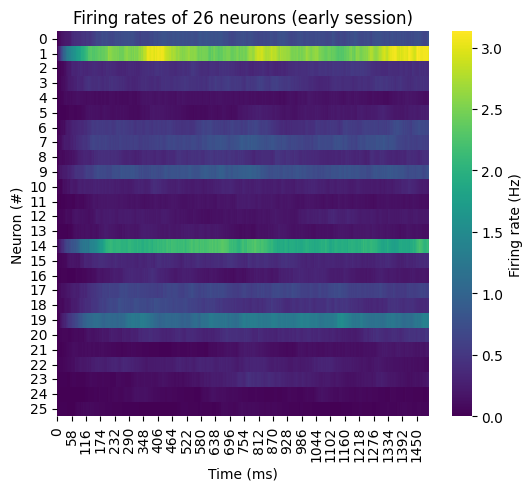

In [229]:
# Average activity in this session
(num_events,num_neurons,num_timebins) = np.shape(firing_rates)

third_of_events = int(num_events/3)

lowres_timebin_size = 100 #in ms

lowres_timebins = int(num_timebins/lowres_timebin_size)

early = firing_rates[0:third_of_events,:,:]
late = firing_rates[-third_of_events:,:,:]

averaged_early = np.mean(early,axis=0)
averaged_late = np.mean(late,axis=0)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))

ax = sns.heatmap(averaged_early,cmap='viridis',cbar_kws={'label': 'Firing rate (Hz)'})

ax.set_title(f'Firing rates of {num_neurons} neurons (early session)')
ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neuron (#)')

Text(45.722222222222214, 0.5, 'Neuron (#)')

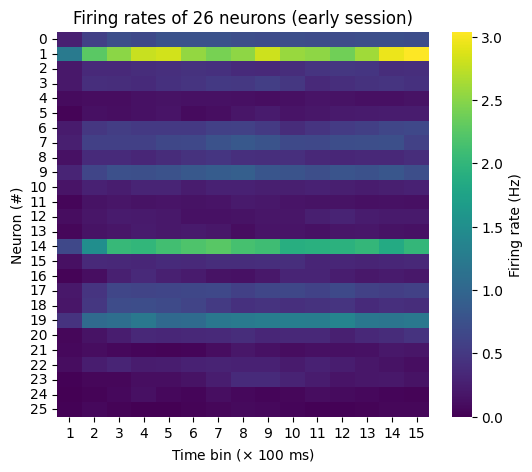

In [230]:
# Low-resolution average activity

lowres_averaged_early = lower_firing_rate_resolution(averaged_early)
lowres_averaged_late = lower_firing_rate_resolution(averaged_late)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))

ax = sns.heatmap(lowres_averaged_early,cmap='viridis',xticklabels=list(range(1,16)),cbar_kws={'label': 'Firing rate (Hz)'})

ax.set_title(f'Firing rates of {num_neurons} neurons (early session)')
ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(r'Time bin ($\times$ 100 ms)')
ax.set_ylabel('Neuron (#)')

Text(45.722222222222214, 0.5, 'Neuron (#)')

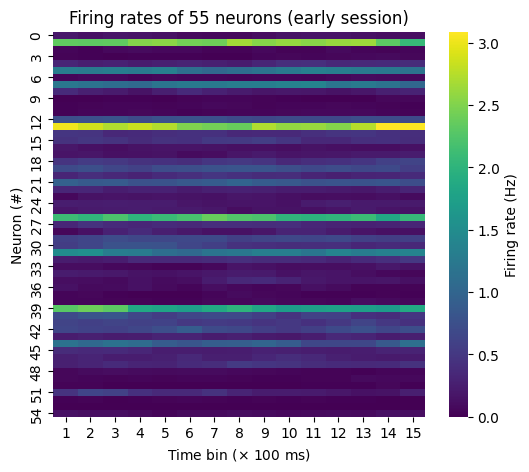

In [231]:
# Pooled over the session
fig, ax = plt.subplots(figsize=(6, 5))

sns.heatmap(early_STR_g2d1[:,5:],cmap='viridis',xticklabels=list(range(1,16)),cbar_kws={'label': 'Firing rate (Hz)'})

ax.set_title(f'Firing rates of {np.shape(early_STR_g2d1)[0]} neurons (early session)')
ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel(r'Time bin ($\times$ 100 ms)')
ax.set_ylabel('Neuron (#)')

# Fig. 2: pipeline to the comparison between in-session and freely moving behavior

Elements for the figure to be built on inkscape later on

In [232]:
# Select freely moving periods from all rats in day 1
off_session_rat_dfs = separate_rats(all_scored_states.query('day == 1 and stage == "WAKEstate"'))

# Bin in time each rat's activity in off-session periods between its beginning and 5 s into each interval
neural_activity_pools = [time_binning_stages(rat,timespan = [0,5]) for rat in off_session_rat_dfs]

In [233]:
# Define a segment length of 2000 ms and randomly choose the leftmost point to each window (which will have 2000 ms length, so it has to be positioned at least 2000 points before the interval's end)

segment_length = 2000
random_window_leftmost_points = [np.random.choice(np.shape(pool[0,:,:])[1] - segment_length) for pool in neural_activity_pools] #using the first interval just because
print(random_window_leftmost_points) #just to check

[1349, 2945, 230, 1230]


In [234]:
def shaded_raster_plot(axis,single_interval_binned_spikes,leftmost_point,segment_length,height,raster_color,plot_shaded_area=True):
  num_neurons,segment_duration = np.shape(single_interval_binned_spikes[:,:])

  axis.set_xlabel('Time (ms)')
  axis.set_ylabel('Neuron (#)')
  axis.eventplot([np.where(single_interval_binned_spikes[current_neuron,:] == 1)[0] for current_neuron in range(num_neurons)],color=raster_color);
  if plot_shaded_area:
    axis.fill_betweenx(y=[0,height],x1=leftmost_point,x2=leftmost_point+segment_length, color='darkorange',alpha=0.7)
  axis.set_ybound(lower=-0.5) #eventplots are centered around integers but expand beyond it; spikes of the 0-th neuron are positioned in the range [-0.5,1.5]

  #force ticks to be integers
  from matplotlib.ticker import MaxNLocator
  axis.yaxis.set_major_locator(MaxNLocator(integer=True))

  return axis

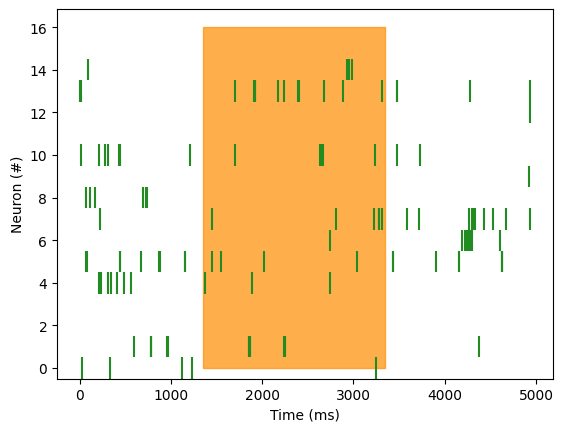

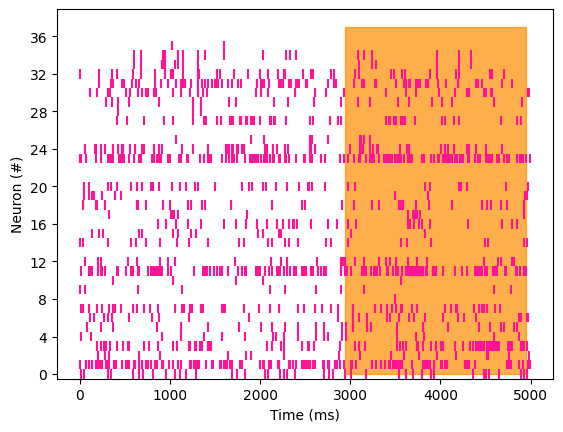

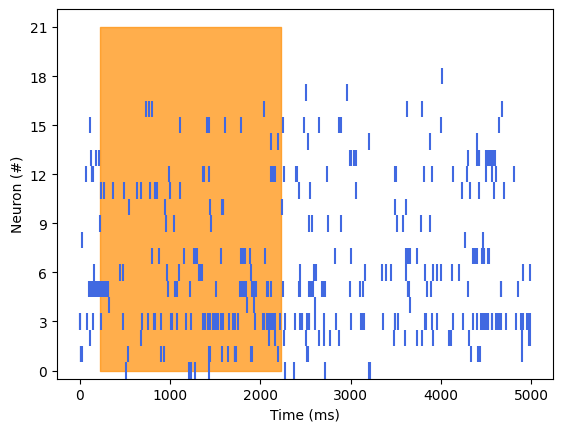

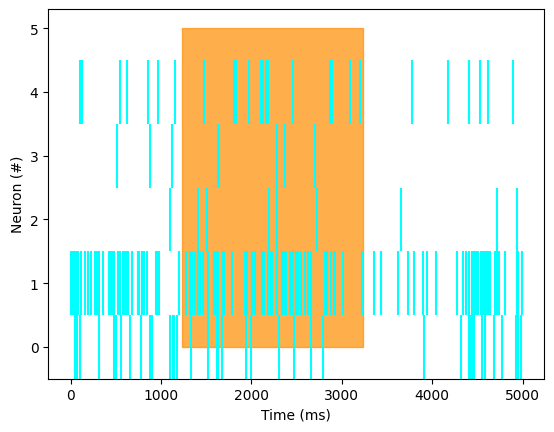

In [235]:
# Plot the rasters
raster_colors = ['forestgreen','deeppink','royalblue','cyan']

for i in range(4):
  fig,axis = plt.subplots()
  pool = neural_activity_pools[i][0,:,:]
  shaded_raster_plot(axis=axis,single_interval_binned_spikes=pool,
                     leftmost_point=random_window_leftmost_points[i],segment_length=2000,height=np.shape(pool)[0],raster_color=raster_colors[i],plot_shaded_area=True)

In [236]:
# Select the spikes within each of the highlighted segments in the raster plots above

segmented_neural_pools = [neural_activity_pools[i][0,:,random_window_leftmost_points[i]:random_window_leftmost_points[i]+segment_length] for i in range(len(neural_activity_pools))]

# Stack the segments into a single neuron pool comprised of neurons from all rats
stacked_segments = np.vstack(segmented_neural_pools)

In [237]:
# Create a colors list so neurons from each animal are colored according to the former raster plots
neuron_counts = [np.shape(pool)[1] for pool in neural_activity_pools]
pooled_raster_color_mapping = []

for i in range(4):
  for item in neuron_counts[i]*[raster_colors[i]]:
    pooled_raster_color_mapping.append(item)

<Axes: xlabel='Time (ms)', ylabel='Neuron (#)'>

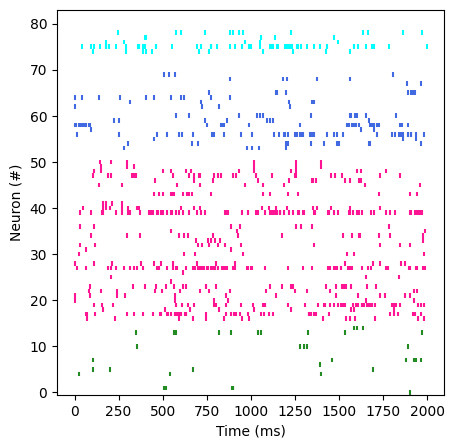

In [238]:
# Plot this raster
fig,ax = plt.subplots(figsize=(5, 5))
shaded_raster_plot(axis=ax,single_interval_binned_spikes=stacked_segments,
                     leftmost_point=0,segment_length=2000,height=np.shape(stacked_segments)[0],raster_color=pooled_raster_color_mapping,plot_shaded_area=False)

Text(45.722222222222214, 0.5, 'Neuron (#)')

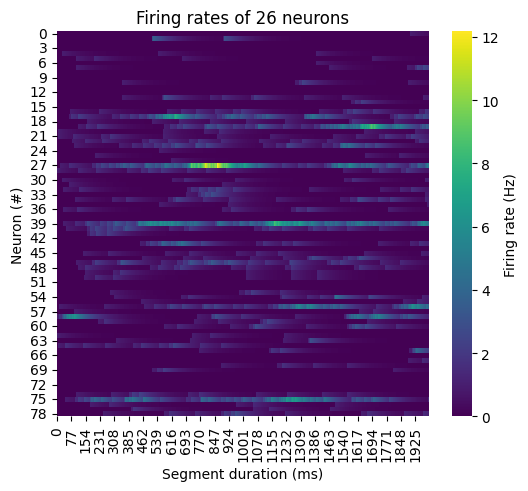

In [239]:
# Convolve the raster
firing_rates = convolve_raster(np.expand_dims(stacked_segments,axis=0))

fig, ax = plt.subplots(figsize=(6, 5))

ax = sns.heatmap(firing_rates[0,:,:],cmap='viridis',cbar_kws={'label': 'Firing rate (Hz)'})

ax.set_title(f'Firing rates of {num_neurons} neurons')
ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Segment duration (ms)')
ax.set_ylabel('Neuron (#)')

In [240]:
#num_neurons_test = np.shape(firing_rates)[1]
#print(np.random.choice(range(num_neurons_test),size=num_neurons_test))

def shuffled_firing_rates(firing_rates_matrix,num_shuffles=4):
  shuffled_rates = []
  for _ in range(num_shuffles):
    shuffled_rates.append(firing_rates_matrix[0,np.random.choice(range(np.shape(firing_rates_matrix)[1]),size=np.shape(firing_rates_matrix)[1],replace=True),:])
  return shuffled_rates

testandooo = shuffled_firing_rates(firing_rates,num_shuffles=5)
#ax = sns.heatmap(test[:,:],cmap='viridis',cbar_kws={'label': 'Firing rate (Hz)'})

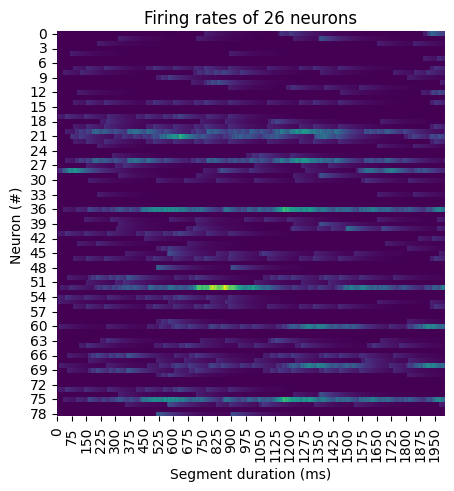

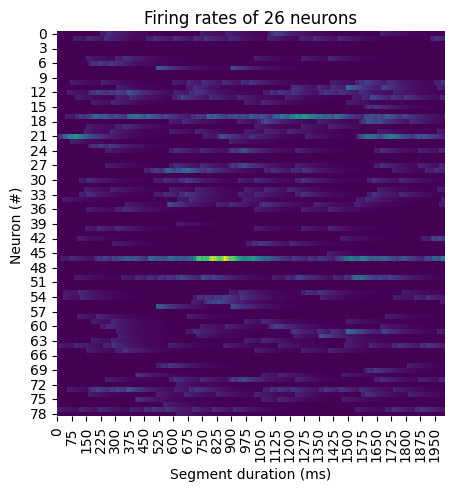

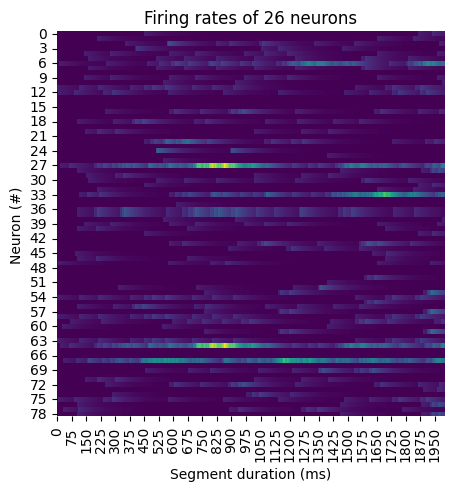

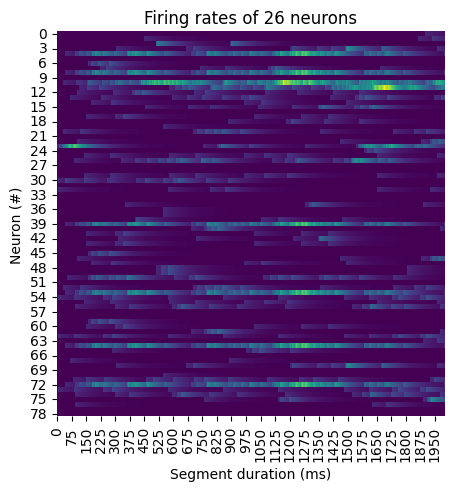

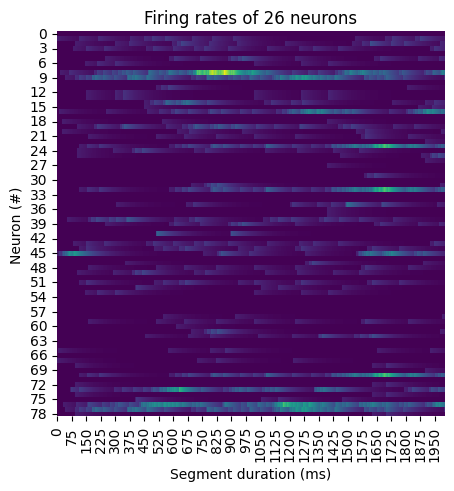

In [241]:
for matrix in testandooo:
  fig, ax = plt.subplots(figsize=(5, 5))

  ax = sns.heatmap(matrix[:,:],cmap='viridis',cbar=False)

  ax.set_title(f'Firing rates of {num_neurons} neurons')
  ax.xaxis.tick_bottom()
  ax.xaxis.set_label_position('bottom')
  ax.set_xlabel('Segment duration (ms)')
  ax.set_ylabel('Neuron (#)')
  plt.show()

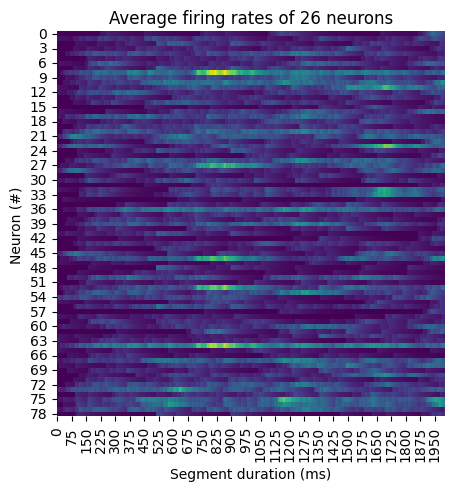

In [242]:
avg_test = np.mean(testandooo,axis=0)

fig, ax = plt.subplots(figsize=(5, 5))

ax = sns.heatmap(avg_test[:,:],cmap='viridis',cbar=False)

ax.set_title(f'Average firing rates of {num_neurons} neurons')
ax.xaxis.tick_bottom()
ax.xaxis.set_label_position('bottom')
ax.set_xlabel('Segment duration (ms)')
ax.set_ylabel('Neuron (#)')
plt.show()

Text(0.5, 0, 'Counts (#)')

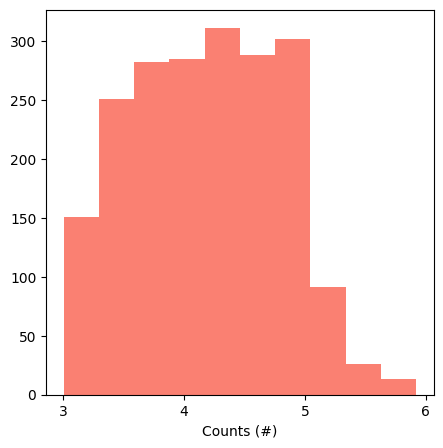

In [243]:
fig_hist,hist_ax = plt.subplots(figsize=(5,5))

hist_ax.hist(avg_test[0,:]+np.random.uniform(low=3,high=5,size=len(avg_test[0,:])),color='salmon')

#force ticks to be integers
from matplotlib.ticker import MaxNLocator
hist_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
hist_ax.set_xlabel('Participation ratio (a.u.)')
hist_ax.set_xlabel('Counts (#)')